In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-28 04:22:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-28 04:22:39 (73.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 10.96 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_hub as tfhub
import os
import random
import string
from helper_functions import *
from sklearn.preprocessing import *
from sklearn.feature_extraction.text import *
from sklearn.naive_bayes import *
from sklearn.pipeline import *

In [ ]:
LOGS_DIR = 'logs/'

In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
data_dir_path = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
train_dir_path = data_dir_path + 'train.txt'
test_dir_path = data_dir_path + 'test.txt'
validation_dir_path = data_dir_path + 'dev.txt'

In [ ]:
filenames = [data_dir_path + filename for filename in os.listdir(data_dir_path)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [ ]:
def read_doc(filename):
  """
  Reads filename (txt) and returns the lines of text as a list

  Args:

    filename: A string containing the target filepath

  Returns:

    A list of strings with one string per line from the target filename
  """
  with open(filename, 'r') as f:
    return f.readlines()


In [ ]:
train_lines = read_doc(train_dir_path)
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
def preprocess_doc(filename):
  """
  Returns a list of dictionaries for each line relating to one abstract, doing the same for all abstracts

  Args:

    filename: A string which is the path of the doc

  Returns:

    A list of dictionaries with preprocesse data from the doc
  """
  input_lines = read_doc(filename)
  abstract_lines = ''
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = ''
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        label_text_split = abstract_line.split('\t')
        line_data['line_number'] = abstract_line_number
        line_data['label'] = label_text_split[0]
        line_data['text'] = label_text_split[1].lower()
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    else:
      abstract_lines += line

  return abstract_samples

In [ ]:
train_samples = preprocess_doc(train_dir_path)
validation_samples = preprocess_doc(validation_dir_path)
test_samples = preprocess_doc(test_dir_path)
len(train_samples), len(validation_samples), len(test_samples)

(180040, 30212, 30135)

In [ ]:
train_samples[:10]

[{'line_number': 0,
  'label': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'label': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'label': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'label': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'label': 'METHODS',
  'text': 'secondary outcome measures included the

In [ ]:
train_df = pd.DataFrame(train_samples)
validation_df = pd.DataFrame(validation_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head(10)

,line_number,label,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


In [ ]:
train_df['label'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: label, dtype: int64

<Axes: ylabel='Frequency'>

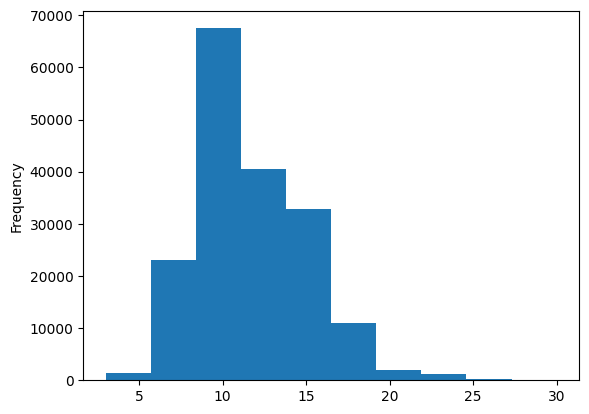

In [ ]:
train_df['total_lines'].plot.hist()

In [ ]:
train_sentences = train_df['text'].to_list()
validation_sentences = validation_df['text'].to_list()
test_sentences = test_df['text'].to_list()

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
one_hot_encoder = OneHotEncoder(sparse_output = False)
train_labels_one_hot_encoded = one_hot_encoder.fit_transform(train_df['label'].to_numpy().reshape(-1,1))
validation_labels_one_hot_encoded = one_hot_encoder.transform(validation_df['label'].to_numpy().reshape(-1,1))
test_labels_one_hot_encoded = one_hot_encoder.transform(test_df['label'].to_numpy().reshape(-1,1))

In [ ]:
label_encoder = LabelEncoder()
train_labels_label_encoded = label_encoder.fit_transform(train_df['label'].to_numpy())
validation_labels_label_encoded = label_encoder.transform(validation_df['label'].to_numpy())
test_labels_label_encoded = label_encoder.transform(test_df['label'].to_numpy())

In [ ]:
total_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
total_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [ ]:
baseline_model = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

baseline_model.fit(X = train_sentences,
                   y = train_labels_label_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_model.score(X = validation_sentences,
                     y = validation_labels_label_encoded)

0.7218323844829869

In [ ]:
baseline_preds = baseline_model.predict(validation_sentences)
baseline_results = calculate_results(y_true = validation_labels_label_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
sentence_lengths = [len(sentence.split()) for sentence in train_sentences]
average_sentence_length = np.mean(sentence_lengths)
average_sentence_length

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

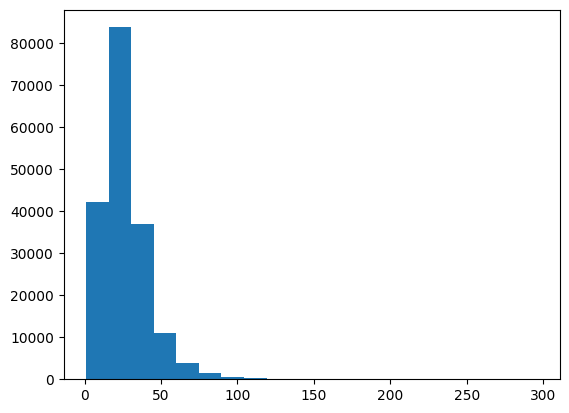

In [ ]:
plt.hist(sentence_lengths, bins = 20)

In [ ]:
output_sentence_length = int(np.percentile(sentence_lengths, 95))
output_sentence_length

55

In [ ]:
max_tokens = 68000

In [ ]:
token_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens = max_tokens,
                                                                               output_sequence_length = output_sentence_length)

In [ ]:
token_vectorizer.adapt(train_sentences)

In [ ]:
sample_sentence = random.choice(train_sentences)
print(f'Text:\n{sample_sentence}')
print(f'\nLength of sentence: {len(sample_sentence.split())}')
print(f'\nVectorized text: {token_vectorizer([sample_sentence])}')

Text:
the participants were then randomly assigned to receive a postoperative course of prednisolone @ mg/kg/d or no prednisolone over @ days .

Length of sentence: 22

Vectorized text: [[   2   60    9  516   92  123    6  175    8  163  656    4 2535 7841
    16   33 2535  145   84    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
token_vocab = token_vectorizer.get_vocabulary()
print(f'Number of words in token_vocab: {len(token_vocab)}')
print(f'Most common words in token_vocab: {(token_vocab[:10])}')
print(f'Least common words in token_vocab: {(token_vocab[-10:])}')

Number of words in token_vocab: 64841
Most common words in token_vocab: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
Least common words in token_vocab: ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
token_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [ ]:
token_embedder = tf.keras.layers.Embedding(input_dim = len(token_vocab),
                                          output_dim = 128,
                                          mask_zero = True,
                                          name = 'token_embedding_layer')

In [ ]:
print(f'Sentence:\n {sample_sentence}\n')
vectorized_sample_sentence = token_vectorizer([sample_sentence])
print(f'Vectorized sentence:\n{vectorized_sample_sentence}\n')
embedded_sample_sentence = token_embedder(vectorized_sample_sentence)
print(f'Embedded sentence:\n{embedded_sample_sentence}\n')

Sentence:
 the participants were then randomly assigned to receive a postoperative course of prednisolone @ mg/kg/d or no prednisolone over @ days .

Vectorized sentence:
[[   2   60    9  516   92  123    6  175    8  163  656    4 2535 7841
    16   33 2535  145   84    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Embedded sentence:
[[[-0.03253154  0.03991138  0.01155235 ...  0.03286452 -0.04740696
    0.0409775 ]
  [ 0.00197904 -0.0339698   0.02600947 ...  0.03498003  0.02382156
    0.0256889 ]
  [-0.03637949  0.01163527  0.03312557 ...  0.03827978 -0.01891283
   -0.04568854]
  ...
  [-0.04463362 -0.0327694  -0.01861227 ... -0.04338708  0.03251157
    0.02938192]
  [-0.04463362 -0.0327694  -0.01861227 ... -0.04338708  0.03251157
    0.02938192]
  [-0.04463362 -0.0327694  -0.01861227 ... -0.04338708  0.03251157
    0.02938192]]]



In [ ]:
train_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot_encoded))
validation_token_data = tf.data.Dataset.from_tensor_slices((validation_sentences, validation_labels_one_hot_encoded))
test_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot_encoded))

In [ ]:
train_token_data = train_token_data.batch(32).prefetch(tf.data.AUTOTUNE)
validation_token_data = validation_token_data.batch(32).prefetch(tf.data.AUTOTUNE)
test_token_data = test_token_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string)
text_vectors = token_vectorizer(inputs)
text_embeddings = token_embedder(text_vectors)
x = tf.keras.layers.Conv1D(64, kernel_size = 5, padding = 'same', activation = 'relu')(text_embeddings)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(total_classes, activation = 'softmax')(x)
model_1 = tf.keras.Model(inputs, outputs, name = 'conv1d_20k')

In [ ]:
model_1.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.003),
                metrics = ['accuracy'])

In [ ]:
model_1_history = model_1.fit(train_token_data,
                              epochs = 5,
                              steps_per_epoch = int(0.25 * len(train_token_data)),
                              validation_data = validation_token_data,
                              validation_steps = int(0.25 * len(validation_token_data)),
                              callbacks=[create_tensorboard_callback(dir_name = LOGS_DIR, experiment_name = 'conv1d_20k')])

Saving TensorBoard log files to: logs//conv1d_20k/20230628-042411
Epoch 1/5
1406/1406 [==============================] - 202s 142ms/step - loss: 0.6825 - accuracy: 0.7456 - val_loss: 0.5782 - val_accuracy: 0.7908
Epoch 2/5
1406/1406 [==============================] - 176s 125ms/step - loss: 0.5733 - accuracy: 0.7942 - val_loss: 0.5370 - val_accuracy: 0.8084
Epoch 3/5
1406/1406 [==============================] - 203s 145ms/step - loss: 0.5455 - accuracy: 0.8059 - val_loss: 0.5200 - val_accuracy: 0.8095
Epoch 4/5
1406/1406 [==============================] - 206s 147ms/step - loss: 0.5234 - accuracy: 0.8120 - val_loss: 0.5386 - val_accuracy: 0.8034
Epoch 5/5
   3/1406 [..............................] - ETA: 3:32 - loss: 0.7070 - accuracy: 0.7778

1406/1406 [==============================] - 5s 3ms/step - loss: 0.7070 - accuracy: 0.7778 - val_loss: 0.5425 - val_accuracy: 0.8026


In [ ]:
model_1.evaluate(validation_token_data)

945/945 [==============================] - 6s 7ms/step - loss: 0.5344 - accuracy: 0.8095


[0.5343501567840576, 0.8095458745956421]

In [ ]:
model_1_preds = tf.argmax(model_1.predict(validation_token_data), axis = 1)
model_1_preds, validation_labels_one_hot_encoded

945/945 [==============================] - 10s 9ms/step


(<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>,
 array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]))

In [ ]:
model_1_results = calculate_results(y_true = validation_labels_label_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 80.9545875810936,
 'precision': 0.8153065151100644,
 'recall': 0.8095458758109361,
 'f1': 0.8046808251288261}

In [ ]:
use = tfhub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                        trainable =  False,
                        name = 'universal_sentence_encoder_layer')

In [ ]:
print(f'Sentence:\n {sample_sentence}\n')
use_sample_sentence = use([sample_sentence])
print(f'Embedded sentence:\n{use_sample_sentence}\n')

Sentence:
 the participants were then randomly assigned to receive a postoperative course of prednisolone @ mg/kg/d or no prednisolone over @ days .

Embedded sentence:
[[-0.00269957 -0.03058234  0.06713414 -0.01453899 -0.05550906  0.0908328
   0.02495463  0.02464805 -0.07921483 -0.00743124  0.09171266  0.02515391
   0.0222116   0.044998    0.06255586  0.01085025 -0.08206999 -0.06386785
  -0.05864268  0.07808933  0.05389902  0.07418694 -0.05868735 -0.01161952
   0.06037422  0.0547921   0.03614981 -0.02388203 -0.07101449 -0.00706474
   0.0468632   0.10073388  0.02062691 -0.00370096 -0.00842364  0.02851322
  -0.04078892 -0.0839383   0.06516314 -0.03590125 -0.02410826  0.08000461
  -0.00021732 -0.0567722   0.06164513  0.07434314  0.06088684  0.01754533
   0.03925993  0.01750667 -0.01076177  0.01587096  0.04798763  0.00422821
   0.04039649  0.02180498 -0.05122846  0.01661418  0.01420086 -0.03860142
  -0.04381341  0.01126274 -0.03235342 -0.03491827  0.00691559 -0.01749843
   0.01360684 -0.0

In [ ]:
inputs = tf.keras.layers.Input(shape = [], dtype = tf.string)
text_use_embedding = use(inputs)
x = tf.keras.layers.Dense(128, activation = 'relu')(text_use_embedding)
outputs = tf.keras.layers.Dense(total_classes, activation = 'softmax')(x)
model_2 = tf.keras.Model(inputs, outputs, name = 'use_20k')

In [ ]:
model_2.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.003),
                metrics = ['accuracy'])

In [ ]:
model_2_history = model_2.fit(train_token_data,
                              epochs = 5,
                              steps_per_epoch = int(0.25 * len(train_token_data)),
                              validation_data = validation_token_data,
                              validation_steps = int(0.25 * len(validation_token_data)),
                              callbacks = [create_tensorboard_callback(dir_name = LOGS_DIR, experiment_name = 'use_20k')])

Saving TensorBoard log files to: logs//use_20k/20230628-043830
Epoch 1/5
1406/1406 [==============================] - 43s 26ms/step - loss: 0.7697 - accuracy: 0.7016 - val_loss: 0.7109 - val_accuracy: 0.7255
Epoch 2/5
1406/1406 [==============================] - 33s 23ms/step - loss: 0.6820 - accuracy: 0.7383 - val_loss: 0.6519 - val_accuracy: 0.7530
Epoch 3/5
1406/1406 [==============================] - 35s 25ms/step - loss: 0.6617 - accuracy: 0.7478 - val_loss: 0.6377 - val_accuracy: 0.7533
Epoch 4/5
1406/1406 [==============================] - 39s 27ms/step - loss: 0.6417 - accuracy: 0.7566 - val_loss: 0.6375 - val_accuracy: 0.7585
Epoch 5/5
   3/1406 [..............................] - ETA: 43s - loss: 0.7754 - accuracy: 0.7222

1406/1406 [==============================] - 10s 7ms/step - loss: 0.7754 - accuracy: 0.7222 - val_loss: 0.6382 - val_accuracy: 0.7575


In [ ]:
model_2.evaluate(validation_token_data)

945/945 [==============================] - 22s 23ms/step - loss: 0.6319 - accuracy: 0.7601


[0.6319370865821838, 0.7600622177124023]

In [ ]:
model_2_preds = tf.argmax(model_2.predict(validation_token_data), axis = 1)

945/945 [==============================] - 20s 21ms/step


In [ ]:
model_2_results = calculate_results(y_true = validation_labels_label_encoded,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 76.00622269296969,
 'precision': 0.7564296492142734,
 'recall': 0.7600622269296968,
 'f1': 0.7555274054662652}

In [ ]:
def split_chars(text):
  return ' '.join(list(text))

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
validation_chars = [split_chars(sentence) for sentence in validation_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
character_lengths = [len(sentence) for sentence in train_sentences]
average_character_length = np.mean(character_lengths)
average_character_length

149.3662574983337

(array([1.69034e+05, 1.07780e+04, 2.09000e+02, 1.60000e+01, 3.00000e+00]),
 array([1.000e+00, 2.780e+02, 5.550e+02, 8.320e+02, 1.109e+03, 1.386e+03]),
 <BarContainer object of 5 artists>)

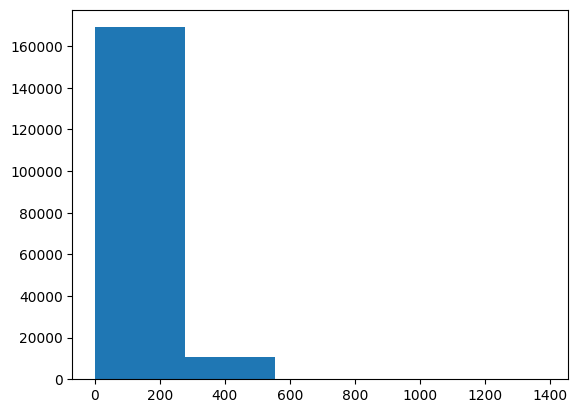

In [ ]:
plt.hist(character_lengths, bins = 5)

In [ ]:
output_character_length = int(np.percentile(character_lengths, 95))
output_character_length

290

In [ ]:
characters = string.ascii_lowercase + string.digits + string.punctuation
characters

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
max_chars = len(characters) +2
max_chars

70

In [ ]:
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens = max_chars,
                                                    output_sequence_length = output_character_length,
                                                    name = 'character_vectorizer_layer')

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of words in char_vocab: {len(char_vocab)}')
print(f'Most common words in char_vocab: {(char_vocab[:10])}')
print(f'Least common words in char_vocab: {(char_vocab[-10:])}')

Number of words in char_vocab: 28
Most common words in char_vocab: ['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's']
Least common words in char_vocab: ['g', 'y', 'w', 'v', 'b', 'k', 'x', 'z', 'q', 'j']


In [ ]:
char_vectorizer.get_config()

{'name': 'character_vectorizer_layer',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 70,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 290,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 28}

In [ ]:
char_embedder = tf.keras.layers.Embedding(input_dim = len(char_vocab),
                                               output_dim = 25,
                                               mask_zero = True,
                                               name = 'character_embedder_layer')

In [ ]:
sample_chars = split_chars(sample_sentence)
print(f'Sentence:\n {sample_chars}\n')
vectorized_sample_chars = char_vectorizer([sample_chars])
print(f'Vectorized sentence:\n{vectorized_sample_chars}\n')
embedded_sample_chars = char_embedder(vectorized_sample_chars)
print(f'Embedded sentence:\n{embedded_sample_chars}\n')

Sentence:
 t h e   p a r t i c i p a n t s   w e r e   t h e n   r a n d o m l y   a s s i g n e d   t o   r e c e i v e   a   p o s t o p e r a t i v e   c o u r s e   o f   p r e d n i s o l o n e   @   m g / k g / d   o r   n o   p r e d n i s o l o n e   o v e r   @   d a y s   .

Vectorized sentence:
[[ 3 13  2 14  5  8  3  4 11  4 14  5  6  3  9 20  2  8  2  3 13  2  6  8
   5  6 10  7 15 12 19  5  9  9  4 18  6  2 10  3  7  8  2 11  2  4 21  2
   5 14  7  9  3  7 14  2  8  5  3  4 21  2 11  7 16  8  9  2  7 17 14  8
   2 10  6  4  9  7 12  7  6  2 15 18 23 18 10  7  8  6  7 14  8  2 10  6
   4  9  7 12  7  6  2  7 21  2  8 10  5 19  9  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  

In [ ]:
inputs = tf.keras.layers.Input(shape = (1, ), dtype = tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embedder(char_vectors)
x = tf.keras.layers.Conv1D(64, kernel_size = 5, padding = 'same', activation = 'relu')(char_embeddings)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(total_classes, activation = 'softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name = 'conv1d_char_20k')

In [ ]:
model_3.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.003),
                metrics = ['accuracy'])

In [ ]:
train_char_data = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot_encoded))
validation_char_data = tf.data.Dataset.from_tensor_slices((validation_chars, validation_labels_one_hot_encoded))
test_char_data = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot_encoded))

In [ ]:
train_char_data = train_char_data.batch(32).prefetch(tf.data.AUTOTUNE)
validation_char_data = validation_char_data.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_data = test_char_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_3_history = model_3.fit(train_char_data,
                              epochs = 5,
                              steps_per_epoch = int(0.25 * len(train_char_data)),
                              validation_data = validation_char_data,
                              validation_steps = int(0.25 * len(validation_char_data)),
                              callbacks = [create_tensorboard_callback(dir_name = LOGS_DIR, experiment_name = 'conv1d_char_20k')])


Saving TensorBoard log files to: logs//conv1d_char_20k/20230628-044543
Epoch 1/5
1406/1406 [==============================] - 45s 31ms/step - loss: 1.3429 - accuracy: 0.4310 - val_loss: 1.2628 - val_accuracy: 0.4840
Epoch 2/5
1406/1406 [==============================] - 57s 40ms/step - loss: 1.2384 - accuracy: 0.4872 - val_loss: 1.1900 - val_accuracy: 0.5201
Epoch 3/5
1406/1406 [==============================] - 44s 31ms/step - loss: 1.1745 - accuracy: 0.5206 - val_loss: 1.1214 - val_accuracy: 0.5508
Epoch 4/5
1406/1406 [==============================] - 56s 40ms/step - loss: 1.0998 - accuracy: 0.5589 - val_loss: 1.0940 - val_accuracy: 0.5557
Epoch 5/5
   1/1406 [..............................] - ETA: 36s - loss: 1.1850 - accuracy: 0.4688

1406/1406 [==============================] - 2s 1ms/step - loss: 1.0799 - accuracy: 0.5000 - val_loss: 1.0599 - val_accuracy: 0.5742


In [ ]:
model_3.evaluate(validation_char_data)

945/945 [==============================] - 13s 14ms/step - loss: 1.0633 - accuracy: 0.5707


[1.0632996559143066, 0.5707334876060486]

In [ ]:
model_3_preds = tf.argmax(model_3.predict(validation_char_data), axis = 1)

945/945 [==============================] - 14s 15ms/step


In [ ]:
model_3_results = calculate_results(y_true = validation_labels_label_encoded,
                                    y_pred = model_3_preds)
model_3_results

{'accuracy': 57.07334833840858,
 'precision': 0.5410135078302345,
 'recall': 0.5707334833840858,
 'f1': 0.5349267246319271}

In [ ]:
token_inputs = tf.keras.layers.Input(shape = [], dtype = tf.string, name = 'token_input')
token_embeddings = use(token_inputs)
token_outputs = tf.keras.layers.Dense(256, activation = 'relu', name = 'token_output')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs, name = 'token_model')

In [ ]:
char_inputs = tf.keras.layers.Input(shape = (1, ), dtype = tf.string, name = 'char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedder(char_vectors)
char_outputs = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24), name = 'char_output')(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_outputs, name = 'char_model')

In [ ]:
token_char_inputs = tf.keras.layers.Concatenate(name = 'token_char_input')([token_model.output, char_model.output])

In [ ]:
token_char_dropout_1 = tf.keras.layers.Dropout(0.5, name = 'token_char_dropout_1')(token_char_inputs)
token_char_dense = tf.keras.layers.Dense(128, activation = 'relu', name = 'token_char_dense')(token_char_dropout_1)
token_char_dropout_2 = tf.keras.layers.Dropout(0.5, name = 'token_char_dropout_2')(token_char_dense)
token_char_outputs = tf.keras.layers.Dense(total_classes, activation = 'softmax', name = 'token_char_output')(token_char_dropout_2)

In [ ]:
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = token_char_outputs,
                         name = 'token_char_20k')

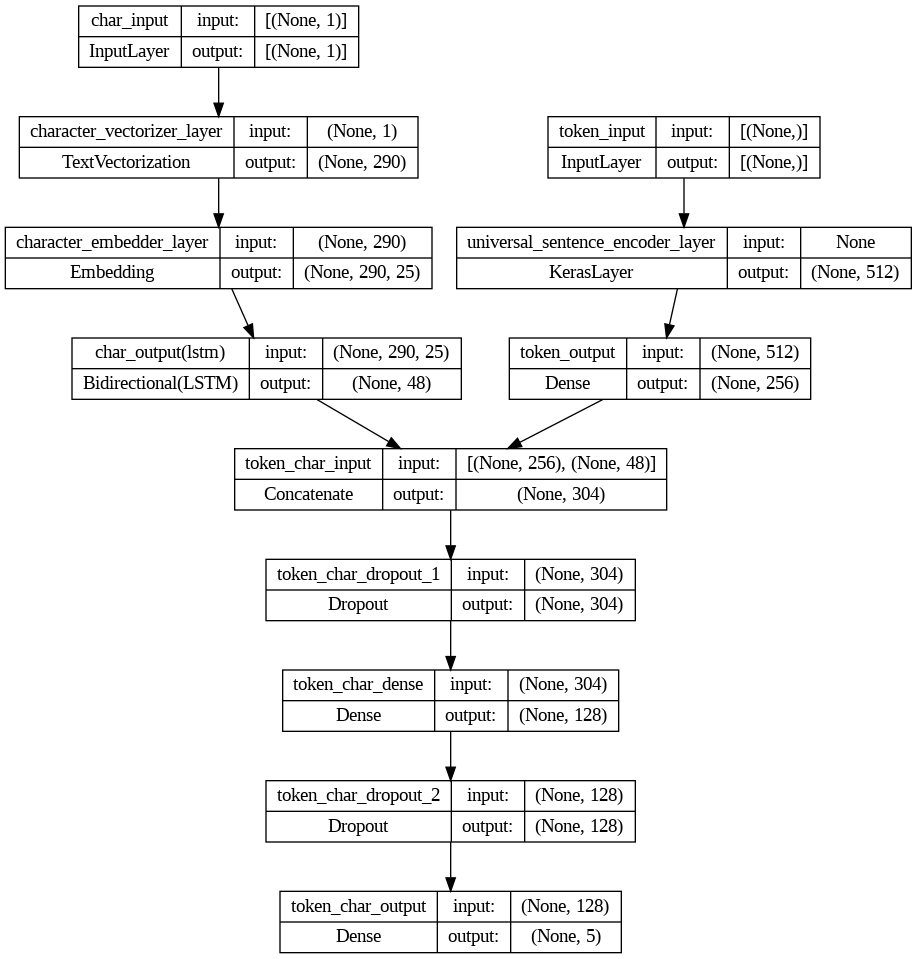

In [ ]:
tf.keras.utils.plot_model(model_4, show_shapes = True)

In [ ]:
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot_encoded)
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels))
validation_token_char_data = tf.data.Dataset.from_tensor_slices((validation_sentences, validation_chars))
validation_token_char_labels = tf.data.Dataset.from_tensor_slices(validation_labels_one_hot_encoded)
validation_token_char_dataset = tf.data.Dataset.zip((validation_token_char_data, validation_token_char_labels))

In [ ]:
train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
validation_token_char_dataset = validation_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_4.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.003),
                metrics = ['accuracy'])

In [ ]:
model_4_history = model_4.fit(train_token_char_dataset,
                              epochs = 5,
                              steps_per_epoch = int(0.25 * len(train_token_char_dataset)),
                              validation_data = validation_token_char_dataset,
                              validation_steps = int(0.25 * len(validation_token_char_dataset)),
                              callbacks = [create_tensorboard_callback(dir_name = LOGS_DIR, experiment_name = 'token_char_20k')])

Saving TensorBoard log files to: logs//token_char_20k/20230628-045448
Epoch 1/5
1406/1406 [==============================] - 733s 521ms/step - loss: 0.7692 - accuracy: 0.7080 - val_loss: 0.6775 - val_accuracy: 0.7422
Epoch 2/5
1406/1406 [==============================] - 688s 489ms/step - loss: 0.7366 - accuracy: 0.7244 - val_loss: 0.6341 - val_accuracy: 0.7566
Epoch 3/5
1406/1406 [==============================] - 591s 420ms/step - loss: 0.7174 - accuracy: 0.7290 - val_loss: 0.6344 - val_accuracy: 0.7591
Epoch 4/5
1406/1406 [==============================] - 515s 366ms/step - loss: 0.7019 - accuracy: 0.7364 - val_loss: 0.6224 - val_accuracy: 0.7691
Epoch 5/5
   3/1406 [..............................] - ETA: 6:52 - loss: 1.0657 - accuracy: 0.6806

1406/1406 [==============================] - 21s 15ms/step - loss: 1.0657 - accuracy: 0.6806 - val_loss: 0.6239 - val_accuracy: 0.7709


In [ ]:
model_4.evaluate(validation_token_char_dataset)

945/945 [==============================] - 73s 77ms/step - loss: 0.6154 - accuracy: 0.7696


[0.6153815984725952, 0.769561767578125]

In [ ]:
model_4_preds = tf.argmax(model_4.predict(validation_token_char_dataset), axis = 1)

945/945 [==============================] - 74s 75ms/step


In [ ]:
model_4_results = calculate_results(y_true = validation_labels_label_encoded,
                                    y_pred = model_4_preds)
model_4_results

{'accuracy': 76.95617635376671,
 'precision': 0.763545804965946,
 'recall': 0.7695617635376671,
 'f1': 0.7647664827853916}

<Axes: ylabel='Frequency'>

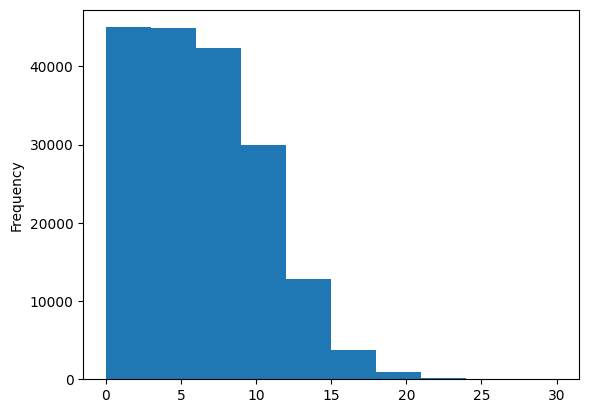

In [ ]:
train_df['line_number'].plot.hist()

In [ ]:
train_line_numbers_one_hot_encoded = tf.one_hot(train_df['line_number'].to_numpy(), depth = 15)
validation_line_numbers_one_hot_encoded = tf.one_hot(validation_df['line_number'].to_numpy(), depth = 15)
test_line_numbers_one_hot_encoded = tf.one_hot(test_df['line_number'].to_numpy(), depth = 15)

<Axes: ylabel='Frequency'>

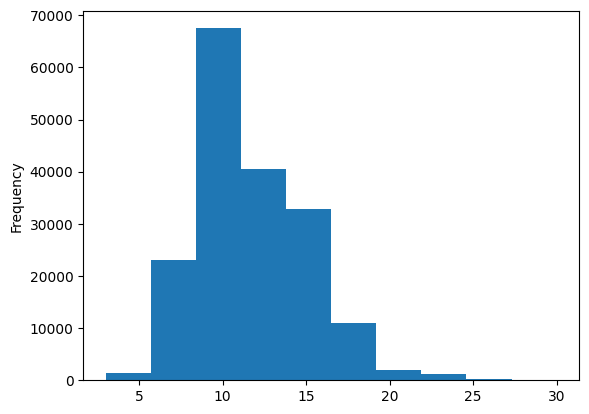

In [ ]:
train_df['total_lines'].plot.hist()

In [ ]:
train_total_lines_one_hot_encoded = tf.one_hot(train_df['total_lines'].to_numpy(), depth = 20)
validation_total_lines_one_hot_encoded = tf.one_hot(validation_df['total_lines'].to_numpy(), depth = 20)
test_total_lines_one_hot_encoded = tf.one_hot(test_df['total_lines'].to_numpy(), depth = 20)

In [ ]:
line_number_inputs = tf.keras.layers.Input(shape = (15, ), dtype = tf.float32, name = 'line_number_input')
line_number_outputs = tf.keras.layers.Dense(32, activation = 'relu', name = 'line_number_output')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

In [ ]:
total_lines_inputs = tf.keras.layers.Input(shape = (20, ), dtype = tf.float32, name = 'total_lines_input')
total_lines_outputs = tf.keras.layers.Dense(32, activation = 'relu', name = 'total_line_output')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_outputs, name = 'total_lines_model')

In [ ]:
token_char_dense = tf.keras.layers.Dense(256, activation = 'relu', name = 'token_char_dense')(token_char_inputs)
token_char_dropout = tf.keras.layers.Dropout(0.5, name = 'token_char_dropout')(token_char_dense)
token_char_positional_inputs = tf.keras.layers.Concatenate(name = 'token_char_positional_inputs')([line_number_model.output,
                                                                                                   total_lines_model.output,
                                                                                                   token_char_dropout])
token_char_positional_outputs = tf.keras.layers.Dense(total_classes, activation = 'softmax', name = 'token_char_positional_output')(token_char_positional_inputs)
model_5 = tf.keras.Model([line_number_model.input,
                          total_lines_model.input,
                          token_model.input,
                          char_model.input],
                         token_char_positional_outputs)

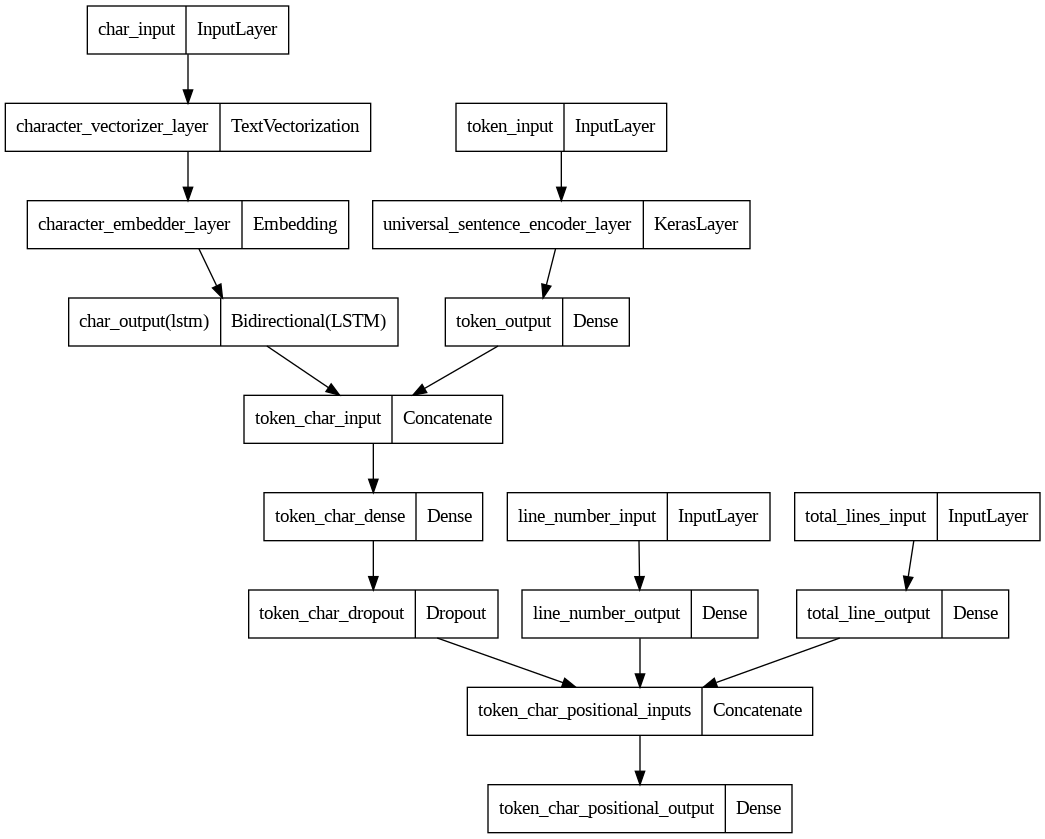

In [ ]:
tf.keras.utils.plot_model(model_5)

In [ ]:
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.003),
                metrics = ['accuracy'])

In [ ]:
train_token_char_positional_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot_encoded, train_total_lines_one_hot_encoded, train_sentences, train_chars))
train_token_char_positional_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot_encoded)
train_token_char_positional_dataset = tf.data.Dataset.zip((train_token_char_positional_data, train_token_char_positional_labels))
validation_token_char_positional_data = tf.data.Dataset.from_tensor_slices((validation_line_numbers_one_hot_encoded, validation_total_lines_one_hot_encoded, validation_sentences, validation_chars))
validation_token_char_positional_labels = tf.data.Dataset.from_tensor_slices(validation_labels_one_hot_encoded)
validation_token_char_positional_dataset = tf.data.Dataset.zip((validation_token_char_positional_data, validation_token_char_positional_labels))

In [ ]:
train_token_char_positional_dataset = train_token_char_positional_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
validation_token_char_positional_dataset = validation_token_char_positional_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_5_history = model_5.fit(train_token_char_positional_dataset,
                              epochs = 5,
                              steps_per_epoch = int(0.25 * len(train_token_char_positional_dataset)),
                              validation_data = validation_token_char_positional_dataset,
                              validation_steps = int(0.25 * len(validation_token_char_positional_dataset)),
                              callbacks = [create_tensorboard_callback(dir_name = LOGS_DIR, experiment_name = 'token_char_positional_20k')])

Saving TensorBoard log files to: logs//token_char_positional_20k/20230628-054414
Epoch 1/5
1406/1406 [==============================] - 566s 380ms/step - loss: 0.9537 - accuracy: 0.8273 - val_loss: 0.9230 - val_accuracy: 0.8440
Epoch 2/5
1406/1406 [==============================] - 522s 371ms/step - loss: 0.9274 - accuracy: 0.8448 - val_loss: 0.9066 - val_accuracy: 0.8542
Epoch 3/5
1406/1406 [==============================] - 520s 370ms/step - loss: 0.9281 - accuracy: 0.8438 - val_loss: 0.9119 - val_accuracy: 0.8533
Epoch 4/5
1406/1406 [==============================] - 530s 377ms/step - loss: 0.9214 - accuracy: 0.8503 - val_loss: 0.9054 - val_accuracy: 0.8486
Epoch 5/5
   3/1406 [..............................] - ETA: 13:42 - loss: 1.0445 - accuracy: 0.7778

1406/1406 [==============================] - 22s 15ms/step - loss: 1.0445 - accuracy: 0.7778 - val_loss: 0.9079 - val_accuracy: 0.8467


In [ ]:
model_5.evaluate(validation_token_char_positional_dataset)

945/945 [==============================] - 75s 79ms/step - loss: 0.9056 - accuracy: 0.8497


[0.9056178331375122, 0.8496623635292053]

In [ ]:
model_5_preds = tf.argmax(model_5.predict(validation_token_char_positional_dataset), axis = 1)

945/945 [==============================] - 77s 77ms/step


In [ ]:
model_5_results = calculate_results(y_true = validation_labels_label_encoded,
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 84.96623858069641,
 'precision': 0.8498985575848049,
 'recall': 0.8496623858069641,
 'f1': 0.8467142920197073}

In [ ]:
all_models_results = pd.DataFrane({
    'naive_bayes_model': baseline_results,
    'token_model': model_1_results,
    'use_model': model_2_results,
    'char_model': model_3_results,
    'token_char_model': model_4_results,
    'token_char_positional_model': model_5_results
})

all_models_results = all_models_results.transpose()
all_models_results.reset_index(inplace = True)
all_models_results

In [ ]:
all_models_results.plot(kind = 'bar', figsize = (10,7)).legend(bbox_to_anchor = (1.0,1.0))

In [ ]:
test_token_char_positional_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot_encoded, test_total_lines_one_hot_encoded, test_sentences, test_chars))
test_token_char_positional_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot_encoded)
test_token_char_positional_dataset = tf.data.Dataset.zip((test_token_char_positional_data, test_token_char_positional_labels))
test_token_char_positional_dataset = test_token_char_positional_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_5_test_preds = tf.argmax(model_5.predict(test_token_char_positional_dataset), axis = 1)

In [ ]:
model_5_test_results = calculate_results(y_true = test_labels_label_encoded,
                                         y_pred = model_5_test_preds)

In [ ]:
model_5_test_results